# DataPreperation, EDA  and DataStorageSolution

This notebook contains data preperation, exploratory data analysis and data storage solution steps. I will start with cleaning the data for data preperation steps. In the EDA part, I will check distributions and correlations of some categorical(Neighbourhood, Room and Property types) and numeric features(Numbers of bedroom, Cleaning fee, Security deposit, Extra person fee, amount of amenities) on our target feature the daily price, to figure out how they affect on pricing policy. I will also visualize these distributions to justify the conclusion.

## 1-) Import Libraries

In [1]:

import numpy as np
import pandas as pd
# import geopandas as gpd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Exploring missing values
import missingno as msno

#to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster

#Set-up Visualization settings
%matplotlib inline

## 2-) Read the Data

The data is publicly available on the website http://insideairbnb.com/get-the-data.html. It contains data from listings in many cities across Europe and America. The data is sourced from publicly available information from the Airbnb site, so there are no privacy issues. The dataset was scraped on 8 February 2021 and contains information on all Amsterdam Airbnb listings that were live on the site on that date. I will use the scraped data Airbnb Amsterdam listings and listings details datasets. There are 2 different datasets; Listings and Listings_details. The first dataset has limited by some features which help to understand and visualize the data better.Second one is more detailed that has further features of listings.

In [2]:
listings = pd.read_csv('../data/listings.csv')
listings_details = pd.read_csv('../data/listings_details.csv')

/Users/admin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print('Listing dataset has {} rows and {} columns'.format(*listings.shape))

print('Listing_detailed dataset has {} rows and {} columns'.format(*listings_details.shape))

Listing dataset has 20030 rows and 16 columns
Listing_detailed dataset has 20030 rows and 96 columns


As I mentioned above listings dataset contains 16 features while the detailed one consists of 96 features. Both datasets have the same number of entries.

## 3-) Merge datasets

Since the listings dataset is not enough to predict the most accurate price, I need some other features from the listings_detailed dataset. Therefore, I need to create new dataset that is usefull and helps predicting the price according to the house attributes by merging these 2 datasets. Let's check first the features that only exists in the detailed dataset. 

In [4]:
features = listings_details.columns[~listings_details.columns.isin(listings.columns)]
print(features)

Index(['listing_url', 'scrape_id', 'last_scraped', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country', 'is_location_exact', 'property_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'weekly_price', 'monthly_price', 'secur

This challenge aims to help hosts to predict the most accurate price by the attributes of the property for listing to Airbnb. These attributes should be concerned with the property itself. However, listings_details dataset contains some features are the attributes of the property itself(property_type, bedrooms, accommodates, amenities,security_deposit, cleaning_fee etc.), some are about the reviews('first_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', etc.) that are received from previous tenants and the rest are about the host himself('host_url', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', etc.). Since the host needs the advised price to list the property and the property can not have any review before listing, I will select and merge with the listings dataset features about the host and review itself to focus on the attributes that are about only the property itself. Furthermore, free text columns will not be selected, as will other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property). Besides, You can only rent out your entire home in Amsterdam for a maximum of 30 nights per year, unless you have a specific permit that allows you to rent out your home for more nights, such as a short term stay license. Therefore, I will grab the availability_30 column from the detailed data instead availability_365 column in the listings dataset.

In [5]:
features_to_combine = ["id", "property_type", "accommodates",'bedrooms','bathrooms','beds', 
                  'amenities', 'square_feet','security_deposit','cleaning_fee', 
                  'extra_people',"maximum_nights", 'availability_30',
                  "weekly_price", "monthly_price",'cancellation_policy']
df = pd.merge(listings, listings_details[features_to_combine], on='id', how='left')
df = df.drop('availability_365', axis=1)
print('Listings dataset has {} rows and {} columns'.format(*df.shape))

Listings dataset has 20030 rows and 30 columns


## 4-) Cleaning and pre-processing

Before the data analyzing, data is need to be cleaned first. Let's see the column informations in the new dataset first.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 0 to 20029
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20030 non-null  int64  
 1   name                            19992 non-null  object 
 2   host_id                         20030 non-null  int64  
 3   host_name                       20026 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   20030 non-null  object 
 6   latitude                        20030 non-null  float64
 7   longitude                       20030 non-null  float64
 8   room_type                       20030 non-null  object 
 9   price                           20030 non-null  int64  
 10  minimum_nights                  20030 non-null  int64  
 11  number_of_reviews               20030 non-null  int64  
 12  last_review                     

### Dropping free-text columns

Free text columns(e.g. name, host_name) will be dropped, as they are not found useful for predicting price.

In [7]:
cols_to_drop = ['name', 'host_name']
df = df.drop(cols_to_drop, axis=1)

Ploting Missing values by Missingno library to check type of missing values.

/Users/admin/opt/anaconda3/lib/python3.8/site-packages/missingno/missingno.py:60: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


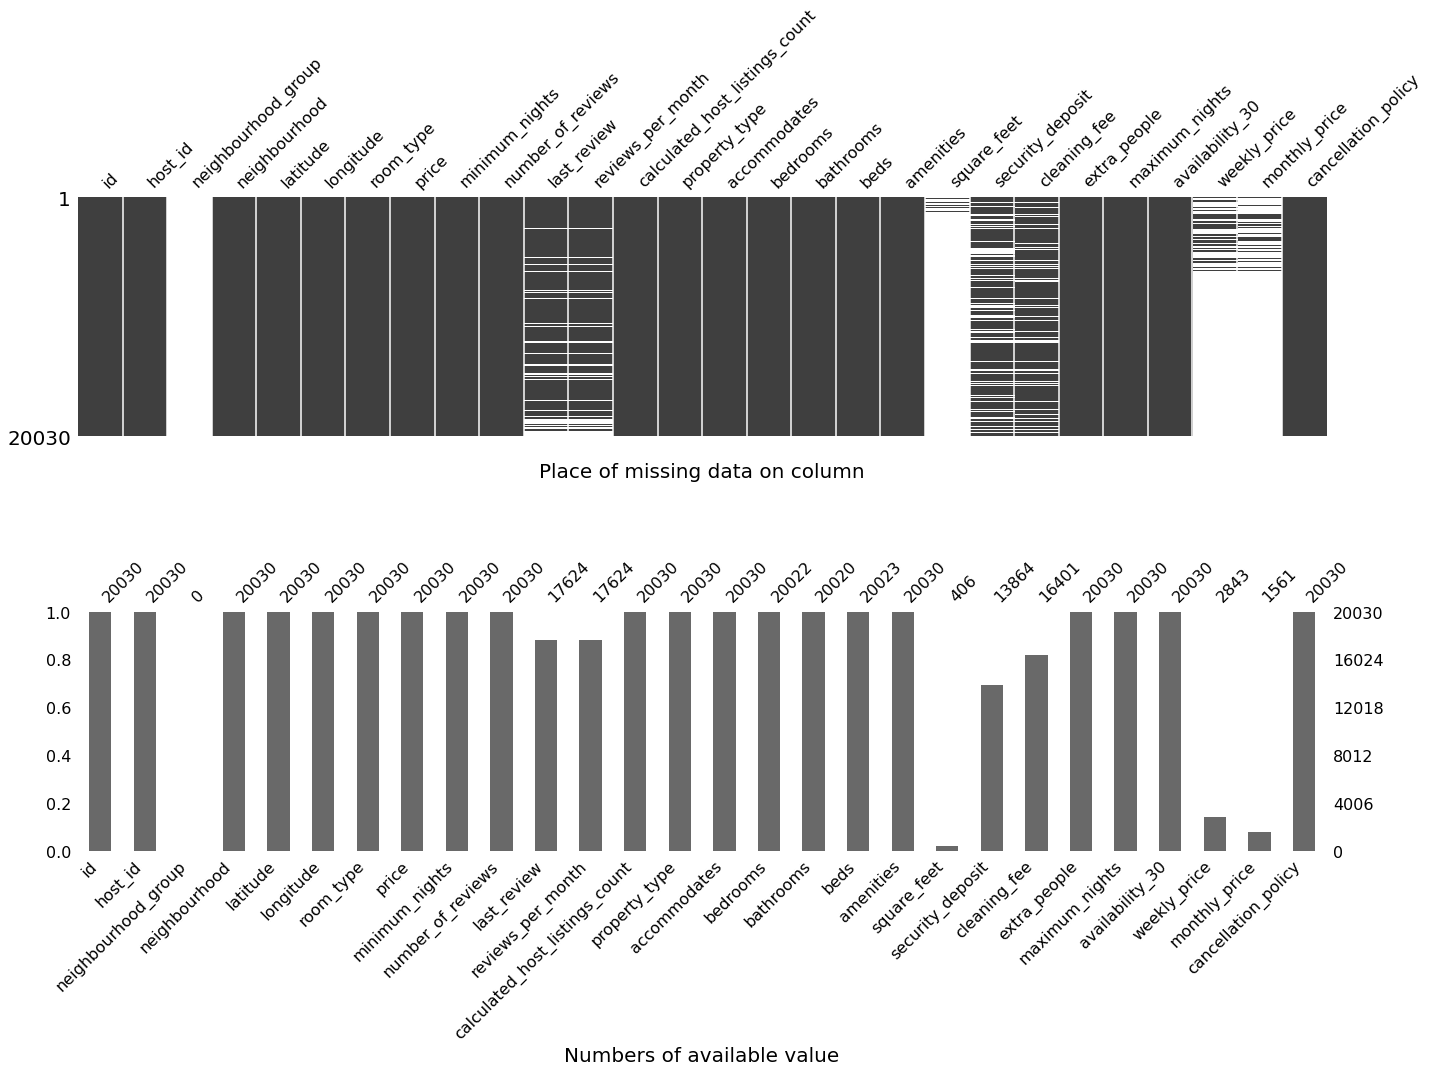

In [8]:
fig, axes = plt.subplots(2,1, figsize =(20,15))
ax_bar = msno.bar(df, ax=axes[1])
ax_matrix = msno.matrix(df, ax=axes[0])
    
ax_bar.set_xlabel('Numbers of available value',fontsize = 20)
ax_matrix.set_xlabel('\nPlace of missing data on column\n\n\n',fontsize = 20)


plt.tight_layout()
plt.show()

Missingno shows the missing data for each column and helps to categorize the pattern of missing data. Some columns have more missing data than others. The name and hostname have less missing values compared to other missing data and seems  not to be correlated with each other. Hence, the missingness, in case, can be attributed as Missing Complateley at Random. The last_review and reviews_per_month have many missing data and neighbourhood_group is entirely missing. Between the last_review and reviews_per_month it can be attributed to a correlation but I will check closer in the next step. However, missingness in the neighbourhood_group seems to be attributed as Missing not at Random. We cannot directly observe the reason for the missingness of data in the neighbourhood_group column. It is also possible to sort the graph by a particular column. Let's sort the values by last_review column to see if there is a pattern in the missing values.

<AxesSubplot:>

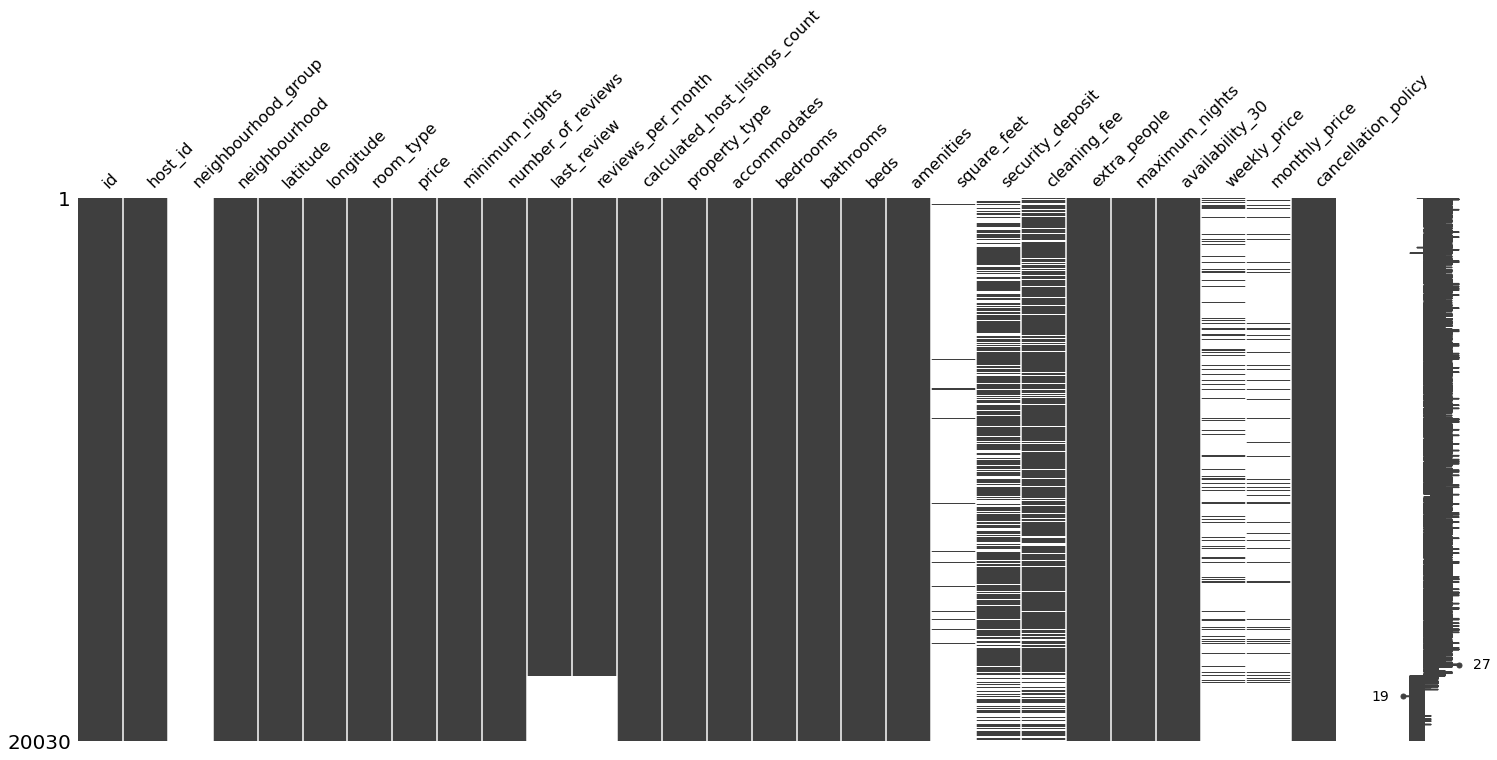

In [9]:
sorted =df.sort_values('last_review')
msno.matrix(sorted)

According to the sorted matrix above, we can say missingness in last_review and reviews_per_month features seem corelated but let's check closer with heatmap, to cement this conclusion further.

<AxesSubplot:>

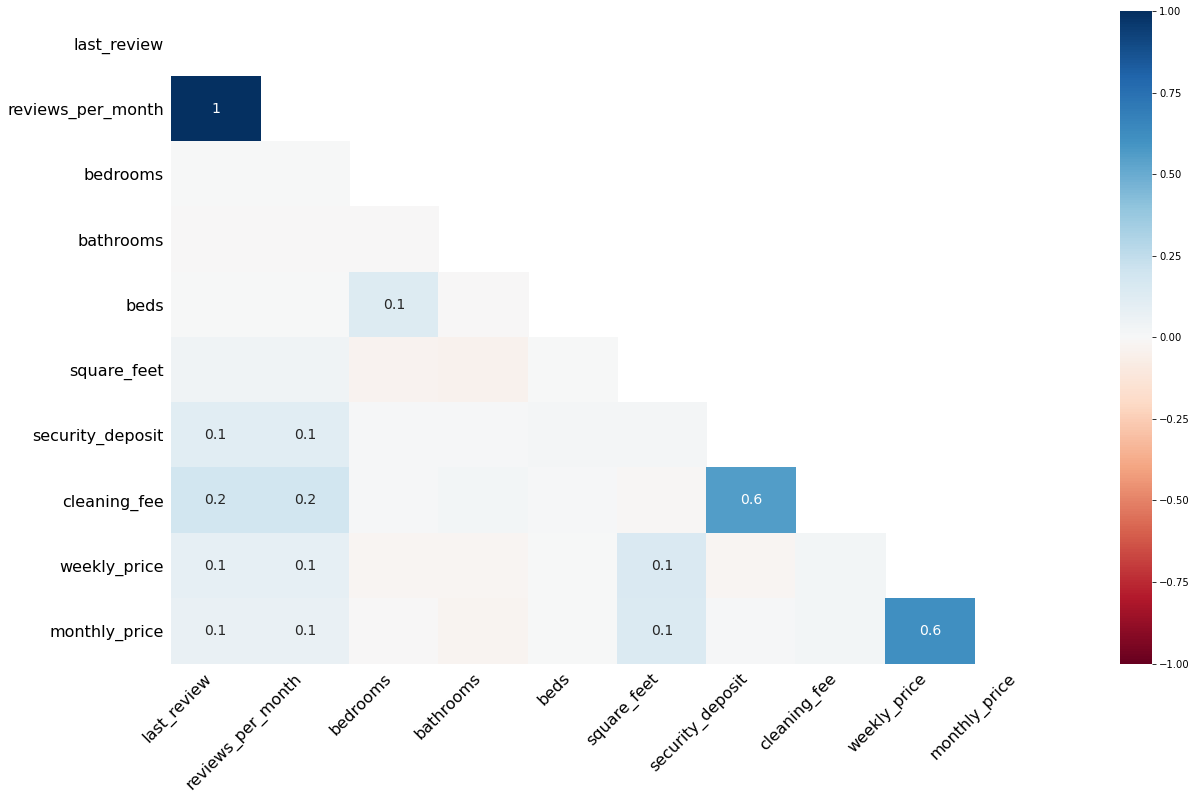

In [10]:
msno.heatmap(df)

The heatmap above shows the exact correlations between features. According to the heatmap, the bathrooms feature doesn't correlate with others, Therefore we can name this missingness as MCAR. Bedrooms and beds have a low correlation therefore we can name the missingness as Missing At Random(MAR) here. Missingness in the last_revies and reviews_per_month columns have a full correlation with each other how I expected, hence this missingness can be named MAR(Missing at Random). Since between weekly_price and monthly_price also security_deposit and cleaning_fee, there are strong correlations with each other, I can name this missingness as MAR. Square_feet also has a low correlation with monthly and weekly prices, hence this missingness can be named MAR(Missing At Random) as well. Finally, it is obvious that square_feet is almost fully missing and the entire neighbourhood_group column is missing. I can name both missingness as MNAR(Missing Not At Random).  

*** Handling MNAR missingness**

I will drop these columns, as they contain a majority of null entries and they can not be used to understand and modelling data.

In [11]:
cols_to_drop = ['square_feet', 'neighbourhood_group']
df.drop(cols_to_drop, axis=1,inplace=True)
df.head(3)

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,...,beds,amenities,security_deposit,cleaning_fee,extra_people,maximum_nights,availability_30,weekly_price,monthly_price,cancellation_policy
0,2818,3159,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,...,2.0,"{Internet,Wifi,""Paid parking off premises"",""Bu...",$100.00,$50.00,$20.00,15,17,NaN,"$1,500.00",strict_14_with_grace_period
1,3209,3806,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,...,2.0,"{Internet,Wifi,Kitchen,""Paid parking off premi...",$300.00,$40.00,$15.00,20,0,$543.00,"$2,000.00",moderate
2,20168,59484,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,...,1.0,"{TV,Internet,Wifi,""Paid parking off premises"",...",NaN,NaN,$0.00,1000,0,NaN,NaN,strict_14_with_grace_period


*** Dropping columns are related to reviews, as neither they can not be used to predicting price nor they are attributes the house itself.**

In [12]:
cols_to_drop = ['last_review', 'reviews_per_month','number_of_reviews']
df.drop(cols_to_drop, axis=1,inplace=True)
df.sample(3)

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,property_type,...,beds,amenities,security_deposit,cleaning_fee,extra_people,maximum_nights,availability_30,weekly_price,monthly_price,cancellation_policy
13743,20450735,6536874,Westerpark,52.384309,4.878910,Entire home/apt,160,3,1,Apartment,...,1.0,"{TV,Wifi,Kitchen,""Paid parking off premises"",H...",NaN,NaN,$0.00,1125,3,NaN,NaN,moderate
17893,27156062,1845099,Westerpark,52.380173,4.875009,Entire home/apt,160,3,1,Apartment,...,1.0,"{Wifi,Kitchen,""Paid parking off premises"",Heat...",$300.00,$40.00,$0.00,1125,15,NaN,NaN,moderate
11570,18047086,124194195,De Baarsjes - Oud-West,52.374025,4.857978,Entire home/apt,100,2,1,Apartment,...,1.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Heating,""...",$250.00,$45.00,$0.00,1125,0,NaN,NaN,moderate


*** Checking the proportion the numbers of missing values**

In [13]:
print('Percentage of the missingness by column')
print(df.isnull().sum()[df.isnull().sum()>0]/ len(df) *100)

Percentage of the missingness by column
bedrooms             0.039940
bathrooms            0.049925
beds                 0.034948
security_deposit    30.783824
cleaning_fee        18.117823
weekly_price        85.806291
monthly_price       92.206690
dtype: float64


The weekly_price and the monthly_price columns can be dropped because they contain a majority of null entries otherwise assigning them with a valid value might occur bias in predicting price.

In [14]:
cols_to_drop = ['weekly_price', 'monthly_price']
df.drop(cols_to_drop, axis=1,inplace=True)

I have added information of related features which I will use in the following steps for EDA. 

## **Attribute Information**


Acronym | Description
---|---
Id | Unique id for the listing
Host_id | Unique id for the host 
Neighborhood | Neighborhood of the property 
Accommodates | The number of people the property accommodates
Bedrooms | The number of bedrooms
Bathrooms |The number of bathrooms
Beds | The number of beds
Property_type| Property types (e.g. apartment) 
Room_type | room type (e.g. entire home, private room, shared room) 
Latitude | Location of the property the level of latitude
Longitude  | Location of the property the level of longitude
Amenities |  The presence or absence of a wide range of amenities (discussed in further depth in a previous post, but including items like TVs, coffee machines, balconies, internet and parking, whether or not the property is child-friendly, allows self check-in or allows pets, and many others)
Maximum_nights |maximum number of nights a guest can stay for the rental 
Minimum_nights | minimum number of nights a guest can stay for the rental
Price | Nightly price for the rental
Security_deposit | the amount required as a security deposit
Cleaning_fee | the amount of the cleaning fee (a fixed amount paid per booking)
Guests_included | the number of guests included in the booking fee
Extra_people | the price per additional guest above the guests_included price
Availability_30 | how many nights are available to be booked in the next 30 days

### Checking and correcting datatypes

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 0 to 20029
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20030 non-null  int64  
 1   host_id                         20030 non-null  int64  
 2   neighbourhood                   20030 non-null  object 
 3   latitude                        20030 non-null  float64
 4   longitude                       20030 non-null  float64
 5   room_type                       20030 non-null  object 
 6   price                           20030 non-null  int64  
 7   minimum_nights                  20030 non-null  int64  
 8   calculated_host_listings_count  20030 non-null  int64  
 9   property_type                   20030 non-null  object 
 10  accommodates                    20030 non-null  int64  
 11  bedrooms                        20022 non-null  float64
 12  bathrooms                       

The table above obviously shows that some features about extra charging(security_deposit, cleaning_fee, extra_people) have the object data type but they are supposed to be a numeric value. Let's check these columns and convert them to numeric.

In [16]:
cols_to_numeric = ['security_deposit', 'cleaning_fee','extra_people']
df[cols_to_numeric].sample(3)

,security_deposit,cleaning_fee,extra_people
9932,$100.00,$50.00,$10.00
11091,$100.00,$50.00,$0.00
547,$250.00,$35.00,$0.00


I will remove the '$' character from the costs and assing them as a numeric value.

In [17]:
df[cols_to_numeric] = df[cols_to_numeric].apply(lambda x:x.str.replace('$', ''))
df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')
df[cols_to_numeric].sample(3)

,security_deposit,cleaning_fee,extra_people
6221,700.0,NaN,0.0
8004,100.0,10.0,0.0
4096,NaN,NaN,0.0


In [18]:
df.describe(include='object')

,neighbourhood,room_type,property_type,amenities,cancellation_policy
count,20030,20030,20030,20030,20030
unique,22,3,31,19034,4
top,De Baarsjes - Oud-West,Entire home/apt,Apartment,"{""translation missing: en.hosting_amenity_49"",...",strict_14_with_grace_period
freq,3515,15889,15582,32,7874


### Handling missingness for the extra charges and the number of bedrooms.

In [19]:
print('Numbers of missing values in each column\n')
print(df.isnull().sum()[df.isnull().sum()>0])

Numbers of missing values in each column

bedrooms               8
bathrooms             10
beds                   7
security_deposit    6571
cleaning_fee        3629
dtype: int64


Let's first handle the missingness number of bedroom, bathroom an bed columns. Missing values will be replaced with the median (to avoid strange fractions).

In [20]:
df_cleaned = df.copy()
cols_to_clean = ['bedrooms','bathrooms','beds']

for col in cols_to_clean:
    df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)

Now it is time to handle missing values about prices. Having a missing value for security deposit is functionally the same as having a security deposit of €0, so missing values will be replaced with 0. As with security deposit, having a missing value for cleaning fee is functionally the same as having a cleaning fee of €0, so missing values will be replaced with 0.

Proportion of missing value for the columns
security_deposit    32.805791
cleaning_fee        18.117823
dtype: float64


					Distribution with missing data


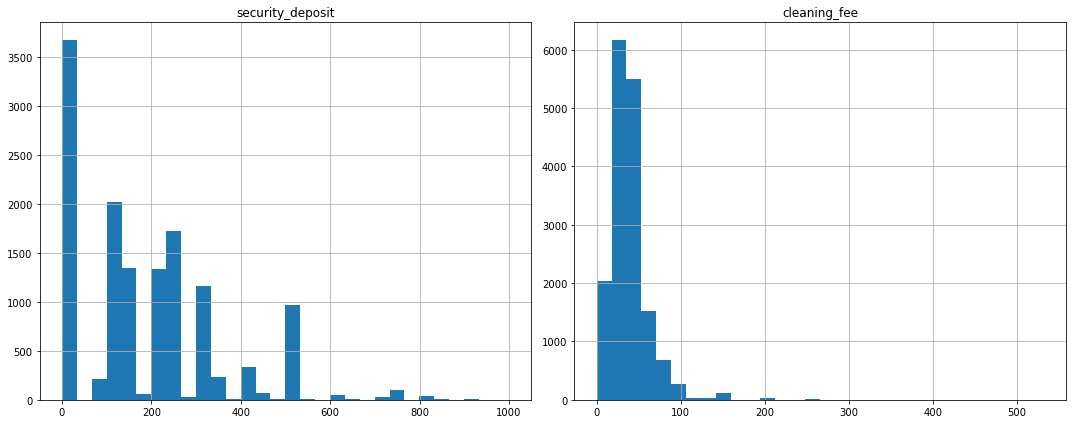

In [21]:
print('Proportion of missing value for the columns')
cols_to_clean = ['security_deposit','cleaning_fee']
print(df_cleaned[cols_to_clean].isnull().sum()/len(df_cleaned) *100)
print('\n\n\t\t\t\t\tDistribution with missing data')


df_cleaned[cols_to_clean].hist(figsize=(15,6),bins=30)
plt.tight_layout()
plt.show()


€0 is the most frequent value for security_deposit. However, it is not the same for the left plot. I will assign €0 to missing data and will check the distribution again, it would create a bias for the cleaning_fee.


				Distribution after cleaning the missingness


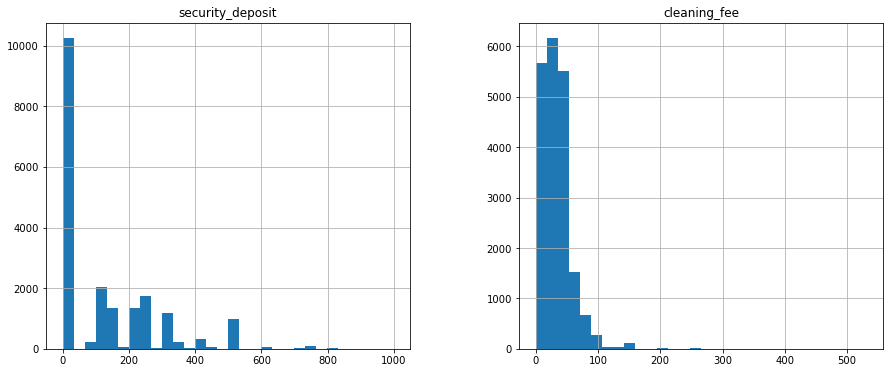

In [22]:
df_cleaned[cols_to_clean] = df_cleaned[cols_to_clean].fillna(0)
print('\n\t\t\t\tDistribution after cleaning the missingness')
df_cleaned[cols_to_clean].hist(figsize=(15,6), bins=30)
plt.show()


Both plots are left-skewed and €0 is the highest rate that meants majority of hosts do not request security deposits and almost a thrid of the hosts do not demand extra cleaning fee from the tenant.

## 5-) Exploratory data analysis

### Numerical Features

Numerical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

#### *a-) Price*

***Question :*** *What is the overall distribution of prices?*

***Answer :***  Nightly advertised prices range from €0 to €8500. The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices (sometimes called 'sticker' prices) correctly. The advertised prices can be set to any arbitrary amount, and these are the prices that show when dates are not entered on the site.
A model is only as good as its data, and unfortunately this model will be predicting advertised prices rather than the prices actually paid. Nevertheless, some cleaning of the particularly unhelpful values will be done. Very small values under €10 will be increased to €10.
There are notable drop-offs in nightly prices at €200 (first graph, orange line), €500 (second graph, orange line) and €1,000 (second graph, red line). Values above €1,000 will be reduced to €1,000.

In [23]:
print(f"Nightly advertised prices range from €{min(df_cleaned.price)} to €{max(df_cleaned.price)}.")

Nightly advertised prices range from €0 to €8500.


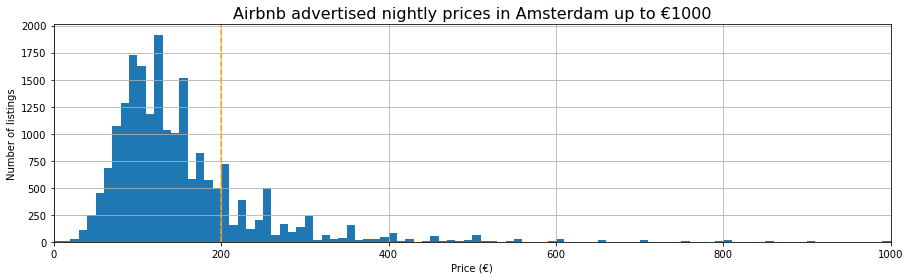

In [24]:
# Distribution of prices from €0 to €1000
plt.figure(figsize=(15,4))
df_cleaned.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Amsterdam up to €1000", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

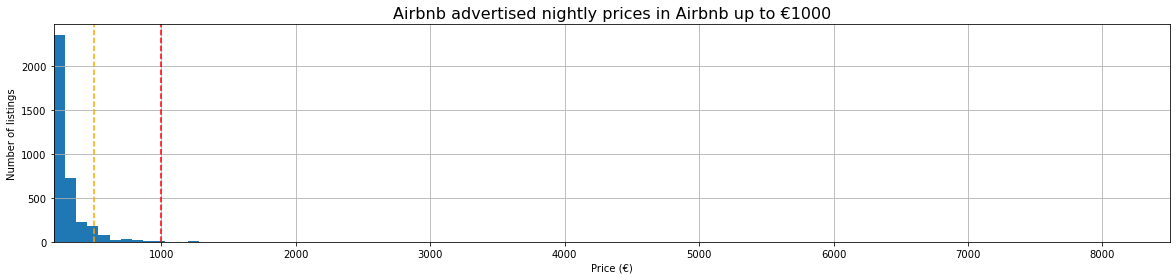

In [25]:
# Distribution of prices from €200 upwards
plt.figure(figsize=(20,4))
df_cleaned.price.hist(bins=100, range=(200, max(df_cleaned.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Airbnb up to €1000", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

In [26]:
# Replacing values under €10 with €10
df_cleaned.loc[df_cleaned.price <= 10, 'price'] = 10

# Replacing values over €1000 with €1000
df_cleaned.loc[df_cleaned.price >= 1000, 'price'] = 1000

#### *b-) Host listings count*

***Question :*** *How many listings do hosts have on average? How many multi-listing hosts are there?*

***Answer :*** The median number of listings that the host of each listing has is 1 about 80 percent of listings, i.e. on average (median) each listing is hosted by a host manages only one listing. The mean is higher (5 in total) due to some hosts managing more numbers of listings.
    Two difficulties in discerning how many listings hosts have on average are: this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 5 listings may be represented up to 5 times in the dataset) a host's other listings may not be in Amsterdam, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once.

In [27]:
print("Median number of listings per host:", int(df_cleaned.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(df_cleaned.calculated_host_listings_count.mean())))
print(f"{int(round(100*len(df_cleaned[df_cleaned.calculated_host_listings_count == 1])/len(df_cleaned)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 5
79% of listings are from hosts with one listing.


#### *c-) Number of people accommodated, bathrooms, bedrooms and beds*


***Question :*** *What are the average number of people accommodated, bathrooms, bedrooms and beds in Airbnb listings in Amsterdam, and how do prices differ?*

***Answer :*** Prices increase with the number of people accommodated. The most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher nightly rates, with diminishing returns coming after about 10 people.
Some properties have very high looking values for some features (e.g. one property claims to have 100 bathrooms, some properties are available for more than 4 people, which is not legal! https://www.dutchamsterdam.nl/3326-airbnb-amsterdam), values above 4 will be reduced to 4 bathrooms, bedrooms, beds and accommodates.

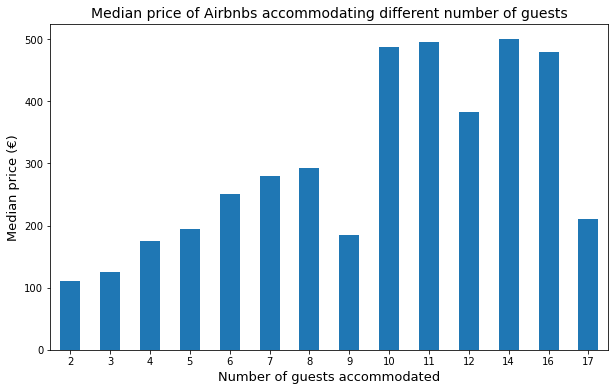

In [28]:
plt.figure(figsize=(10,6))
df_cleaned.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (€)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

In [29]:
def count_and_price_plot(col, figsize=(9,6)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(121)
    ax1 = df_cleaned[col].value_counts().sort_index().plot.bar(color=['r']).set(ylabel='Count',title=col)
   
    ax2 = fig.add_subplot(122)
    ax2 = df_cleaned.groupby(col).price.median().plot.bar().set(ylabel='Median price (€)',title='Median price of Airbnbs {}'.format(col), xlabel=f'{col}\n\n')
    
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

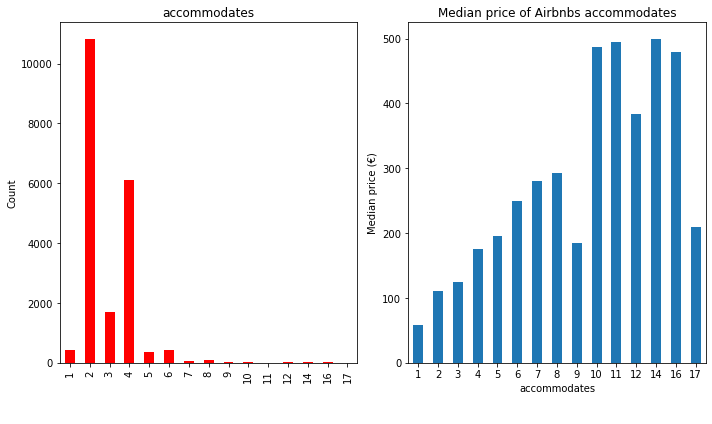

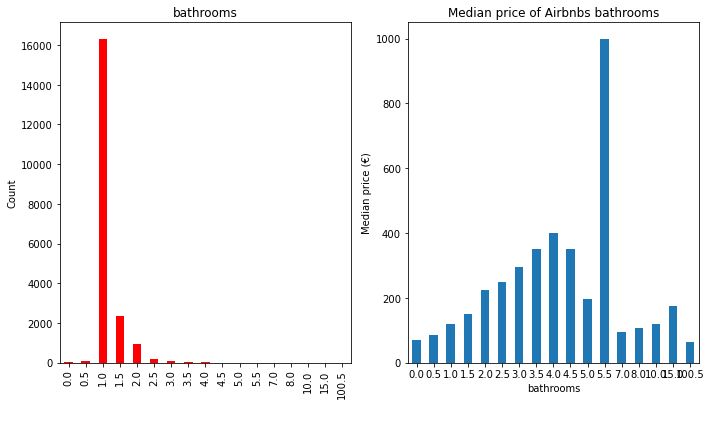

In [30]:
for col in ['accommodates', 'bathrooms']:
    count_and_price_plot(col, figsize=(10,6))



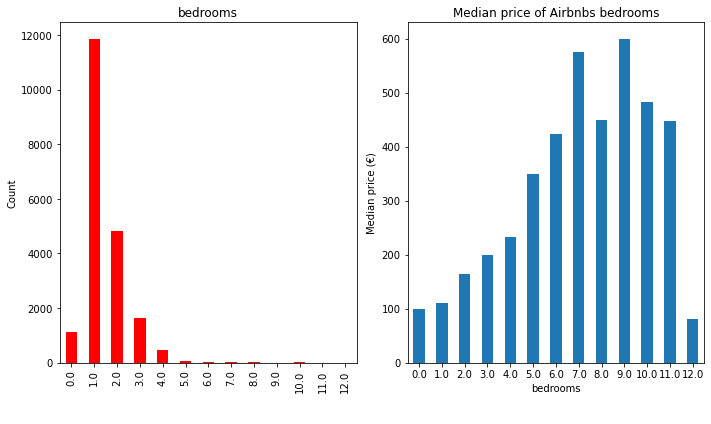

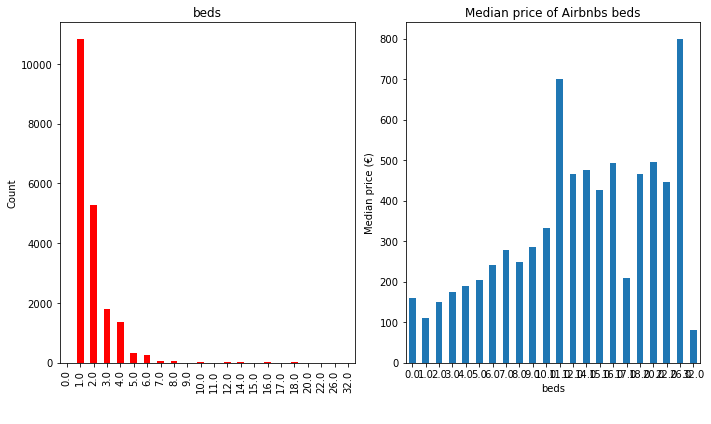

In [31]:
for col in ['bedrooms', 'beds']:
    count_and_price_plot(col, figsize=(10,6))

In [32]:
# Replacing bathroom values over 4 with 4
df_cleaned.loc[df_cleaned.bathrooms >= 4, 'bathrooms'] = 4
# Replacing bedrooms values over 4 with 4
df_cleaned.loc[df_cleaned.bedrooms >= 4, 'bedrooms'] = 4
# Replacing beds values over 4 with 4
df_cleaned.loc[df_cleaned.beds >= 4, 'beds'] = 4
# Replacing accommodates values over 4 with 4
df_cleaned.loc[df_cleaned.accommodates >= 4, 'accommodates'] = 4



#### *d-) Extra fees*

***Question :*** *What are the average price of extra people, security deposit and cleaning fee in Airbnb listings in Amsterdam, and how do prices differ?*

***Answer :*** Majority of hosts do not request extra charges from tenants that we already explained that in the previous data cleaning part. Therefore, I did not count €0 charges. Average cleanining fee is €41 while range is from €0 to €531, average charging for an extra person per night is €33 while the range from €0 to €280, and average of security deposit is demand from the tenant is €247 while has a range from €0 to €999. From the plots below, we can observe that except from some values all three feature has a normal distribution according to daily price of property. With the increase in the extra fees, there is also an increase in the daily price. However, same amount of extra fee can be demanded for the properties that they have different daily prices, though many hosts in the Airnbn Amsterdam do not charge the tenant with any extra fees. 

In [33]:
def function(col):
    plt.figure(figsize=(9,6))
#     df_cleaned.loc[df_cleaned[col]>0].groupby(col)['price'].median().plot.bar()
    sns.relplot(kind='line',x=col, y='price', data=df_cleaned, ci=None)
    plt.title('Price distribution of Airbnbs according to {}'.format(col), fontsize=22)
    plt.xlabel('{} (€)'.format(col), fontsize=13)
    plt.ylabel('Price (€)', fontsize=13)
    plt.locator_params(axis='x', nbins=10)
    plt.xticks(rotation=0)
    plt.xlim(left=0.5)
    plt.show()
    

<Figure size 648x432 with 0 Axes>

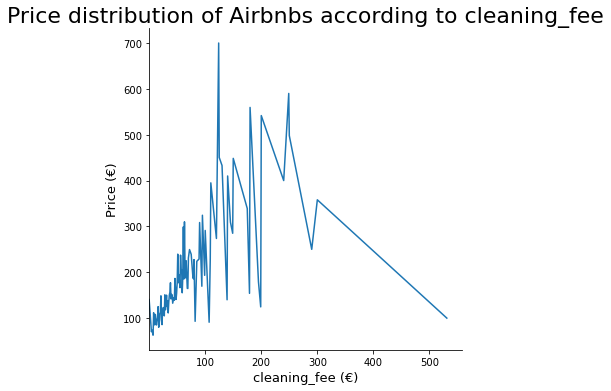

cleaning_fee costs range from €0.0 to €531.0.

Average cleaning_fee charging in the Amsterdam listings: €41



<Figure size 648x432 with 0 Axes>

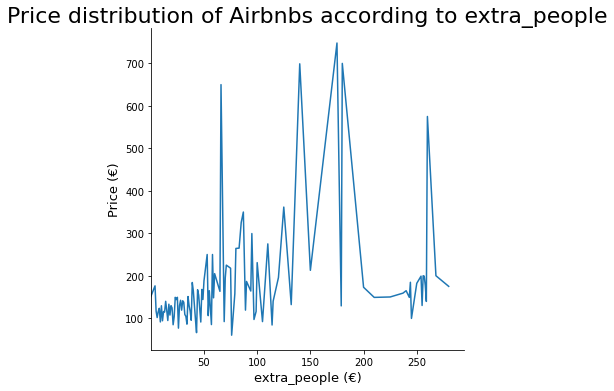

extra_people costs range from €0.0 to €280.0.

Average extra_people charging in the Amsterdam listings: €33



<Figure size 648x432 with 0 Axes>

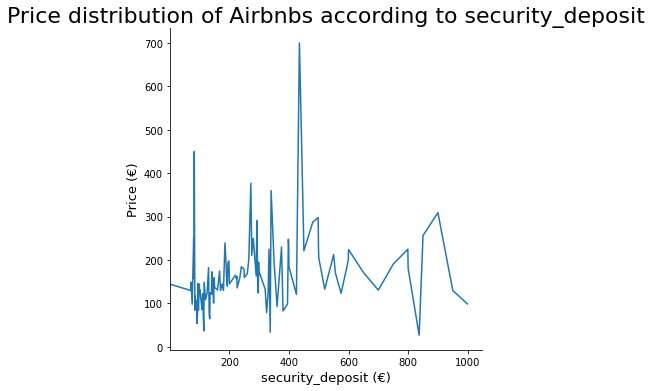

security_deposit costs range from €0.0 to €999.0.

Average security_deposit charging in the Amsterdam listings: €247



In [34]:
for col in ['cleaning_fee', 'extra_people', 'security_deposit']:
    function(col)
    print(f"{col} costs range from €{min(df_cleaned[col])} to €{max(df_cleaned[col])}.\n")
    print('Average {} charging in the Amsterdam listings: €{}\n'.format(col,round(df_cleaned[col].loc[df_cleaned[col]>0].mean())))

### Categorical Features

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

#### *a-) Property and room types*

***Question :*** *What are the most common property and room types, and how do prices differ?*

Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories 'apartment', 'house' and 'other' will be used, as most properties can be classified as either apartments or houses.

In [35]:
df_cleaned.property_type.value_counts()

Apartment                 15582
House                      1523
Townhouse                   649
Bed and breakfast           455
Loft                        384
Boat                        372
Condominium                 323
Houseboat                   225
Guest suite                 152
Aparthotel                   73
Serviced apartment           63
Other                        51
Guesthouse                   43
Villa                        32
Boutique hotel               28
Cabin                        14
Bungalow                     12
Cottage                      12
Hotel                         7
Casa particular (Cuba)        5
Tiny house                    5
Hostel                        4
Barn                          4
Chalet                        3
Campsite                      2
Camper/RV                     2
Lighthouse                    1
Earth house                   1
Nature lodge                  1
Castle                        1
Tent                          1
Name: pr

In [36]:
# Replacing categories that are types of houses or apartments
df_cleaned.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df_cleaned.loc[~df_cleaned.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

***Answer :*** About 80% of properties are apartments. The remainder are houses or more uncommon property types (e.g. 'bed and breakfast' or 'host').However, the pattern with prices is slightly different. House is the most expensive property type in the amsterdam rather than appartment or other types. About 55% of listings are entire homes (i.e. you are renting the entire property on your own). Most of the remainder are private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). Fewer than 1% are shared rooms (i.e. you are sharing a room with either the property owner or other guests). The pattern with prices is similar with distribution for the room type. If a property is rented as entirely the price is getting expensive and the cheapest one are shared rooms. 

In [37]:
def category_count_and_price_plot(col, figsize=(9,6)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(121)
    ax1 = df_cleaned[col].value_counts().plot.bar(width=0.5,color=['r']).set(ylabel='Count',title=col)
    
    ax2 = fig.add_subplot(122)
    ax2 = df_cleaned.groupby(col).price.median().plot.bar().set(ylabel='Median price (€)',title='Median price of Airbnbs {}'.format(col))
    
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

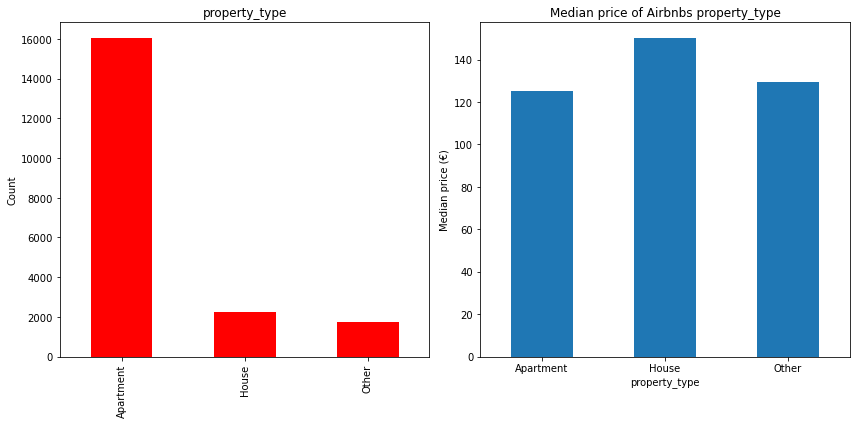

Apartment    0.800250
House        0.111682
Other        0.088068
Name: property_type, dtype: float64


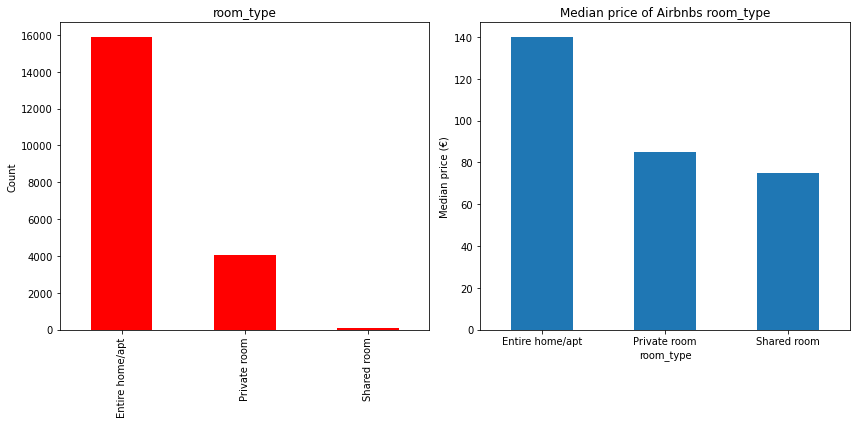

Entire home/apt    0.793260
Private room       0.203495
Shared room        0.003245
Name: room_type, dtype: float64


In [38]:
for col in ['property_type', 'room_type']:
    category_count_and_price_plot(col, figsize=(12,6))
    print(df_cleaned[col].value_counts(normalize=True))

#### *b-) Amenities*

***Question :*** *What is the average number amenities in Airbnb listings in Amsterdam, and how does the increase in numbers affect the price?*

***Answer :*** Amenities increase the luxuriousness of property. I want to check that effect on price. However, amenities are not seperated in the data they are stored in a one column as one big block of text, I seperated and calculated the number of amenities and then compared eachothers. Number of amenity range from 1 to 73. Average number of amenities in the Amsterdam listings is 18 amenities for a property. With the increase in the number of amenities, there is also an increase in the daily price.

In [39]:
df_cleaned['amenities_number'] = df_cleaned.amenities.str.count(',') + 1
freq = df_cleaned.loc[df_cleaned.amenities_number<5]
print(freq[['amenities_number','amenities']].sample(3))
print(f'\n\nAverage number of amenities in Amsterdam listings is {df_cleaned.amenities_number.median()}')

       amenities_number                                          amenities
4336                  4                 {TV,Wifi,Kitchen,"Smoke detector"}
11788                 2  {"translation missing: en.hosting_amenity_49",...
2302                  1                                                 {}


Average number of amenities in Amsterdam listings is 18.0


<Figure size 648x432 with 0 Axes>

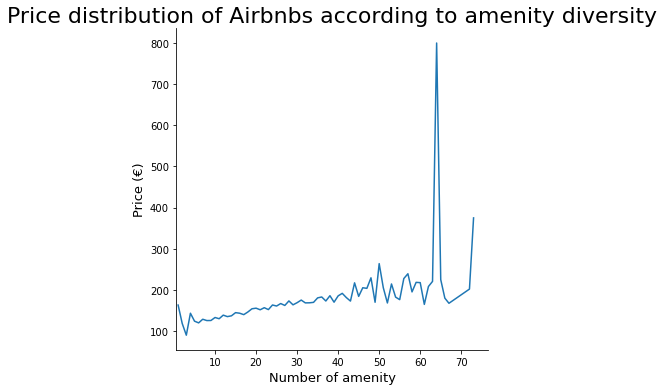

Number of amenities range from 1 to 73


In [40]:
plt.figure(figsize=(9,6))
# df_cleaned.loc[df_cleaned['amenities_number']>0].groupby(col)['price'].median().plot.bar()
sns.relplot(kind='line',x='amenities_number', y='price', data=df_cleaned, ci=None)  
plt.title('Price distribution of Airbnbs according to amenity diversity'.format(col), fontsize=22)
plt.xlabel('Number of amenity'.format(col), fontsize=13)
plt.ylabel('Price (€)', fontsize=13)
plt.locator_params(axis='x', nbins=10)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()


print(f'Number of amenities range from {min(df_cleaned.amenities_number)} to {max(df_cleaned.amenities_number)}')

#### c-) *Neighbourhood* 

***Question :*** Which areas have the most Airbnb properties, and which are the most expensive?

***Answer :*** De Baarsjes-Oud-West has the most Airbnb properties, followed by De Pijp-Rivierenbuurt. Inner Amsterdam neighbourhoods have significantly more listings than outer Amsterdam neighbourhoods. However, the pattern with prices is slightly different. Centrum-West and Centrum-Oost are the most expensive area - Centrum is a famously expensive area to live in the Amsterdam.


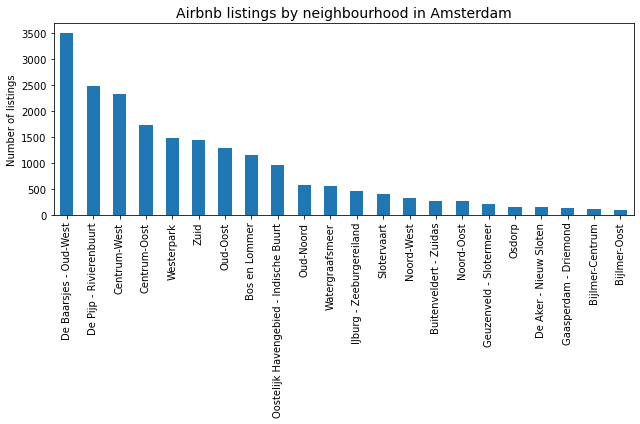

In [41]:
plt.figure(figsize=(9,6))
df_cleaned.neighbourhood.value_counts().plot.bar()
plt.title("Airbnb listings by neighbourhood in Amsterdam", fontsize=14)
plt.ylabel('Number of listings')
plt.tight_layout()
plt.show()

In [42]:
lats2021 = df_cleaned['latitude'].tolist()
lons2021 = df_cleaned['longitude'].tolist()
locations = list(zip(lats2021, lons2021))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

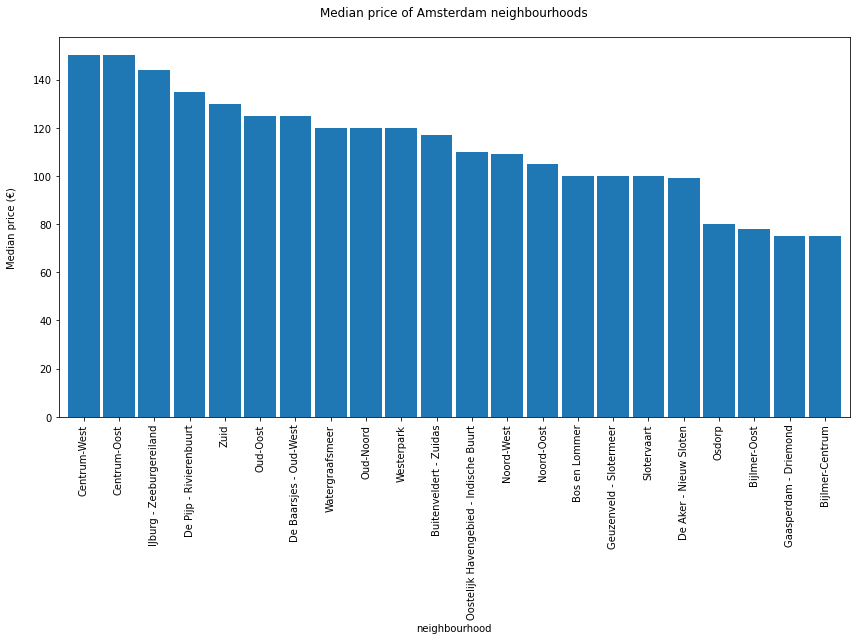

Median price of neighbourhoods range from €75 to €150


In [43]:
freq = df_cleaned.groupby('neighbourhood')['price'].median().sort_values(ascending=False)
freq.plot(kind='bar',figsize = (12,9), width = 0.9).set(title = 'Median price of Amsterdam neighbourhoods\n', ylabel='Median price (€)\n')

plt.tight_layout()
plt.show()
print(f'Median price of neighbourhoods range from €{min(freq)} to €{max(freq)}')

## 6-) Preparing the data for modeling

### Dropping columns and assessing multi-collinearity

*Categorical variables will now be one-hot encoded*

In [44]:
df_transformed = df_cleaned.drop('amenities', axis=1)
df_transformed = pd.get_dummies(df_transformed)
df_transformed.head()

,id,host_id,latitude,longitude,price,minimum_nights,calculated_host_listings_count,accommodates,bedrooms,bathrooms,...,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,property_type_Apartment,property_type_House,property_type_Other,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_60
0,2818,3159,52.365755,4.941419,59,3,1,2,1.0,1.5,...,0,1,0,1,0,0,0,0,1,0
1,3209,3806,52.390225,4.873924,160,4,1,4,2.0,1.0,...,1,0,0,1,0,0,0,1,0,0
2,20168,59484,52.365087,4.893541,80,1,2,2,1.0,1.0,...,1,0,0,0,1,0,0,0,1,0
3,25428,56142,52.373114,4.883668,125,14,2,3,1.0,1.0,...,1,0,0,1,0,0,0,0,1,0
4,27886,97647,52.386727,4.892078,150,2,1,2,1.0,1.0,...,0,1,0,0,0,1,0,0,1,0


In [45]:
df_transformed.to_csv('transformed.csv', index=False)

*The dataset can now be assessed for multi-collinearity.*

In [46]:
def heatmap_plot(df):
     # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20,20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());
    plt.title('Correlation between features\n', fontsize = 20)
    plt.show()

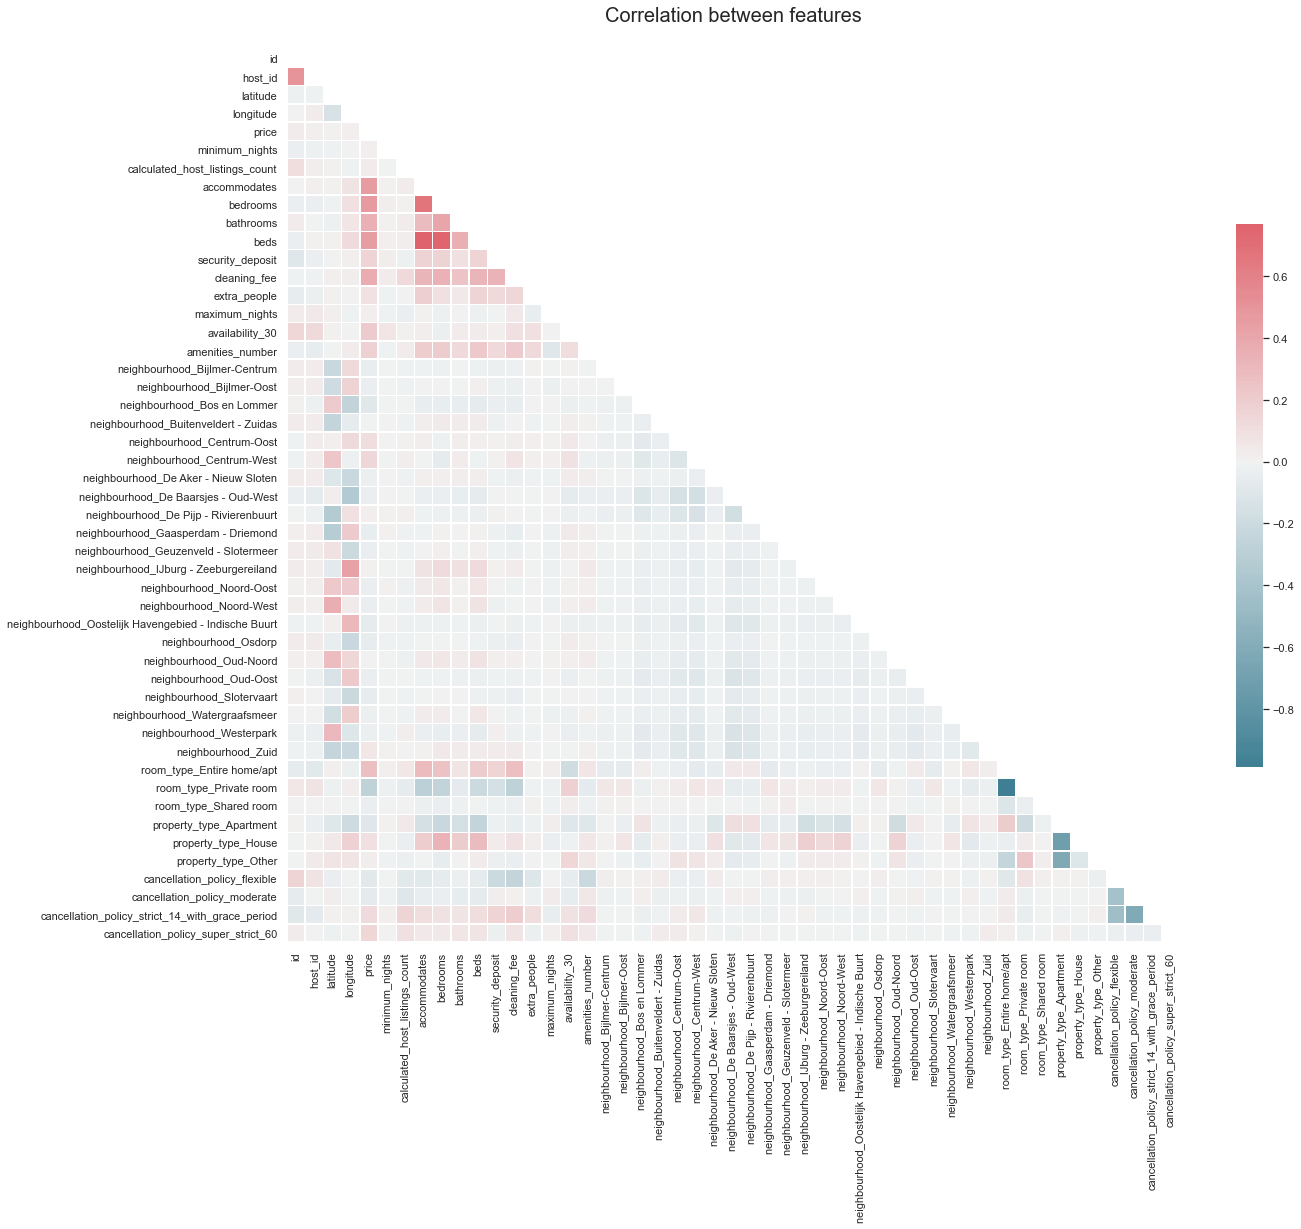

In [47]:
heatmap_plot(df_transformed)

**It doesn't look like there are any significant collinear relationships with neighbourhoods except from Centrum-Oost and Centrum-West, so these will temporarily be dropped to produce a clearer heatmap for the remaining features:**

In [48]:
columns_to_drop = list(df_transformed.columns[df_transformed.columns.str.startswith('neighbourhood')])
columns_to_drop

['neighbourhood_Bijlmer-Centrum',
 'neighbourhood_Bijlmer-Oost',
 'neighbourhood_Bos en Lommer',
 'neighbourhood_Buitenveldert - Zuidas',
 'neighbourhood_Centrum-Oost',
 'neighbourhood_Centrum-West',
 'neighbourhood_De Aker - Nieuw Sloten',
 'neighbourhood_De Baarsjes - Oud-West',
 'neighbourhood_De Pijp - Rivierenbuurt',
 'neighbourhood_Gaasperdam - Driemond',
 'neighbourhood_Geuzenveld - Slotermeer',
 'neighbourhood_IJburg - Zeeburgereiland',
 'neighbourhood_Noord-Oost',
 'neighbourhood_Noord-West',
 'neighbourhood_Oostelijk Havengebied - Indische Buurt',
 'neighbourhood_Osdorp',
 'neighbourhood_Oud-Noord',
 'neighbourhood_Oud-Oost',
 'neighbourhood_Slotervaart',
 'neighbourhood_Watergraafsmeer',
 'neighbourhood_Westerpark',
 'neighbourhood_Zuid']

In [49]:
del columns_to_drop[4:6]
columns_to_drop

['neighbourhood_Bijlmer-Centrum',
 'neighbourhood_Bijlmer-Oost',
 'neighbourhood_Bos en Lommer',
 'neighbourhood_Buitenveldert - Zuidas',
 'neighbourhood_De Aker - Nieuw Sloten',
 'neighbourhood_De Baarsjes - Oud-West',
 'neighbourhood_De Pijp - Rivierenbuurt',
 'neighbourhood_Gaasperdam - Driemond',
 'neighbourhood_Geuzenveld - Slotermeer',
 'neighbourhood_IJburg - Zeeburgereiland',
 'neighbourhood_Noord-Oost',
 'neighbourhood_Noord-West',
 'neighbourhood_Oostelijk Havengebied - Indische Buurt',
 'neighbourhood_Osdorp',
 'neighbourhood_Oud-Noord',
 'neighbourhood_Oud-Oost',
 'neighbourhood_Slotervaart',
 'neighbourhood_Watergraafsmeer',
 'neighbourhood_Westerpark',
 'neighbourhood_Zuid']

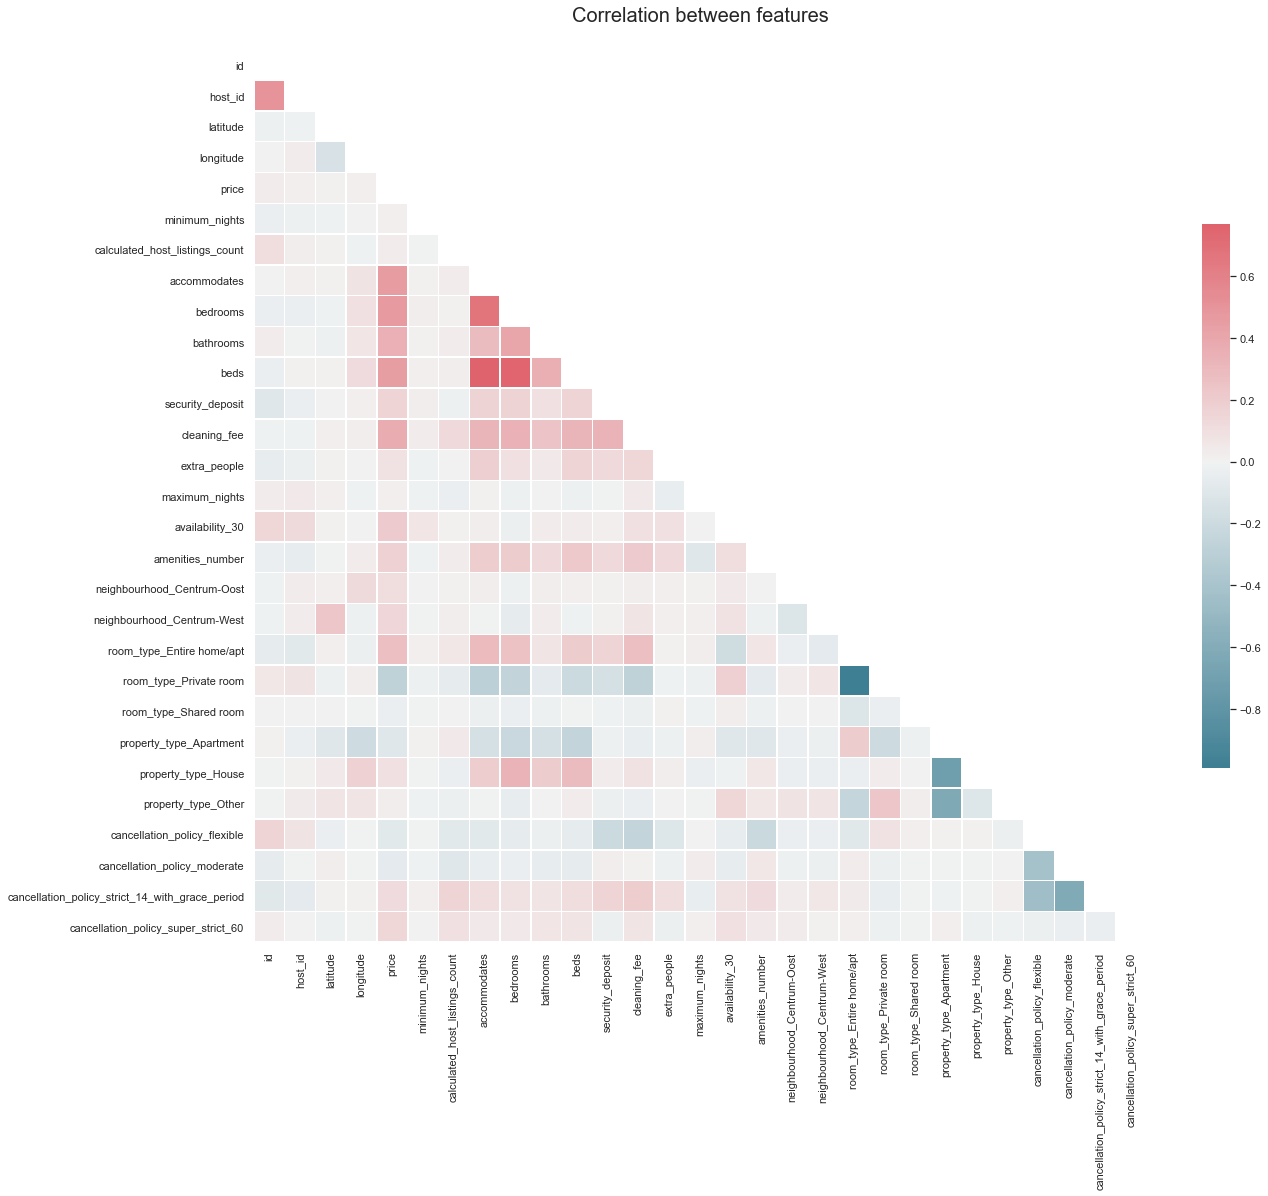

In [50]:
heatmap_plot(df_transformed.drop(columns_to_drop,axis=1))

***Areas of multi-collinearity:***

* Beds, bedrooms and the number of people that a property accommodates are highly correlated. The number of people accommodated has traditionally been a more high priority search parameter on Airbnb, as it is more relevant for private and shared rooms than the number of bedrooms (and is still the second highest priority parameter when searching on the site, after dates 
* There are strong negative correlations between houses and apartments, and between private rooms and entire homes . I got those multi-collinearities after one-hot encoding Room type and Property type features. Therefore, I will not drop any of them and keep all for the modelling.

In [51]:
to_drop = ['beds',
           'bedrooms']
df_transformed.drop(to_drop, axis=1, inplace=True)

**Dropping columns that have weak or non-correlations with price**

Some features does not have any correlations or such a weak correlations with price. I dont need them to train the model. Therefore, I will drop them and also check the outliers among the reamining numeric features.

## 7-) Data Solution Storage

In [52]:
drop_columns_permenantly = ['id','host_id','latitude', 'longitude', 'minimum_nights','calculated_host_listings_count','maximum_nights','extra_people','availability_30']
cols_cancelation_policiy = df_transformed.columns[df_transformed.columns.str.startswith('cancellation')]
for each_column in cols_cancelation_policiy:
    drop_columns_permenantly.append(each_column)
drop_columns_permenantly
df_transformed.drop(drop_columns_permenantly,axis=1,inplace=True)


Now it is time to check correlation the remaining features with price.

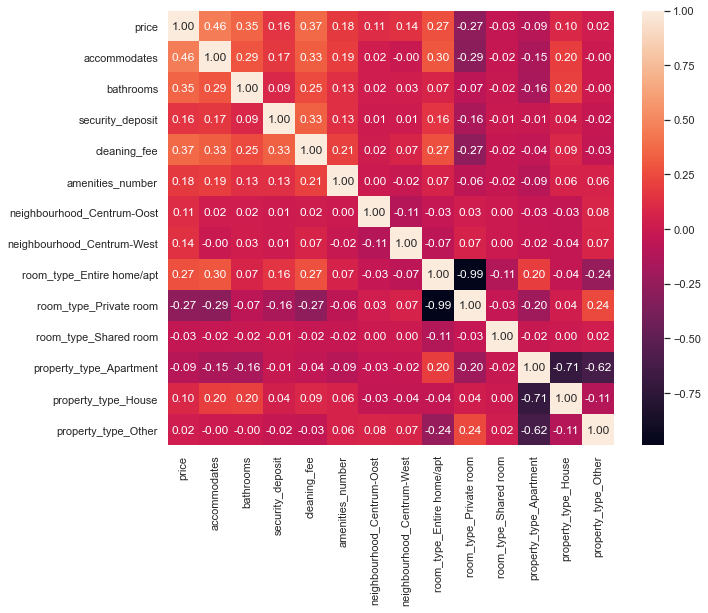

In [53]:
plt.figure(figsize=(10,8))
sns.heatmap(df_transformed.drop(columns_to_drop,axis=1).corr(),cbar=True,
            annot=True, fmt='.2f')
plt.show() 


The number of the property accommodates and bathrooms, cleaning fee, and room type correlate highly with the price. Moreover, the number of amenities and security deposit show also a normal correlation with the price. Furthermore, if the property is located in the Centrum-Oost or Centrum-West also has a correlation with the price of the property. 
These results are also supported with plots above in the EDA part that is examined each feature detailed. On the other hand, the number of the minimum and maximum nights, the number of other properties of the host in the Airbnb,availabilty days for in a month, and the type of property have a weak or no correlation with the price according to the correlation heatmap.

To conclude, the features above in the heatmap will be used in the modelling phase. I will export the cleaned data after handling with the outliers and could use the exported data for the apply Machine Leaning alghorithms.

### ***Dropping  outliers***

Datasets can contain extreme values that are outside the range of expected and unlike the remaining data. These are callad 'Outliers' and for the following part, the modelling part, those data could reason for bias or decreasing the accuracy. Therefore, I will handle with outliers before the modelling part and will remove all of them from the dataset. I create a method which checks the outliers also clear the data set from outliers.

In [54]:
def check_outliers(df, features_to_check, drop = False):
    df_cleaned_outliers = df.copy()
    for column_name in features_to_check:
        column_data = df_cleaned_outliers[column_name]
        Q1 = column_data.quantile(0.25) # 25th percentile of the data of the given column
        Q3 = column_data.quantile(0.75) # 75th percentile of the data of the given column
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #
        outliers = column_data[~((column_data >= Q1 - outlier_step) & (column_data <= Q3 + outlier_step))].index.tolist()  
        if not drop:
            print("Number of Outliers for the '{}' feature: {} value".format(column_name, len(outliers)))
        
        if drop:
            if len(outliers)>0:
                print("{} outliers from '{}' feature removed".format(len(outliers),column_name))
                df_cleaned_outliers.drop(outliers, errors = 'ignore',inplace = True)
    if drop:
        return df_cleaned_outliers

Let's find the continuous features, since outliers could be exist only in the continuous features.

In [55]:
cols_to_check_outliers = ['accommodates','bathrooms', 'cleaning_fee','security_deposit','price']


check_outliers(df_transformed, cols_to_check_outliers)

Number of Outliers for the 'accommodates' feature: 0 value
Number of Outliers for the 'bathrooms' feature: 3705 value
Number of Outliers for the 'cleaning_fee' feature: 223 value
Number of Outliers for the 'security_deposit' feature: 247 value
Number of Outliers for the 'price' feature: 1272 value


Majority outliers exist in the bathroom and price columns. Accomodates feature does not contain any outlier. Let's plot the outliers first and then drop them from the dataset.

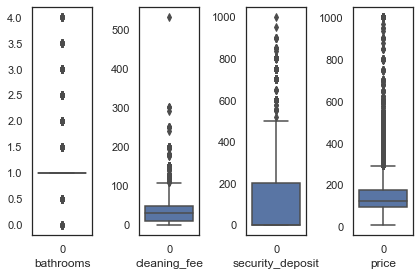

In [56]:
#Remove accommodates from the list, as it does not contain any outlier.
del cols_to_check_outliers[0]
#Create the plot for the reamining features
fig, axes = plt.subplots(1,4)
count = 0
for each_feature in cols_to_check_outliers:
    feature_data = df_transformed[each_feature]
    sns.boxplot(data = feature_data, orient ='v', ax = axes[count]).set(xlabel=f'{each_feature}')
    count+=1
plt.tight_layout()

If I remove the outliers from bathrooms feature, bathroom numbers will be the same for all properties and it will not make a sense to keep that column anymore. Therefore, I will keep the numbers in this feature and drop the outliers from the remaining columns. 

In [57]:
drop_outliers =['cleaning_fee', 'security_deposit', 'price']
df_transformed_cleaned = check_outliers(df_transformed,drop_outliers, drop= True)
print(f'Dataset has {df_transformed_cleaned.shape[0]} rows after dropping the outliers')

223 outliers from 'cleaning_fee' feature removed
239 outliers from 'security_deposit' feature removed
1022 outliers from 'price' feature removed
Dataset has 18546 rows after dropping the outliers


I will store the cleaned data locally, that means I select the data storage solution as a csv file that is stored on a local disk.

In [58]:
df_transformed_cleaned.to_csv('../data/listings_preprocessed.csv',index=False)